# notebook v5d

1. smooth both sine and step data
1. finite diff. deriative of each
1. concatenate derivatives to form training data of GP
1. train $\dot{T}_{S,1}=f(T_{S,1},\ \dot{Q_1})$
1. apply GP to each test separately
1. compare each to benchmark

## Setup

In [2]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tabulate import tabulate

In [3]:
tests = ["sine", "step"]
ii = range(len(tests))

In [4]:
data = list(pd.read_csv(os.path.join(dir, f"tclab_{test}_test.csv")) for test in tests)

tvec = list(data[i]["Time"].values for i in ii)
Q1 = list(data[i]["Q1"].values for i in ii)
TS1 = list(data[i]["T1"].values for i in ii)

Q1f = list(interp1d(tvec[i], Q1[i], kind='previous') for i in ii)
dQ1f = [interp1d(tvec[0], np.cos(Q1[0]), kind='previous'), 
        interp1d(tvec[1], np.zeros(len(Q1[1])), kind='previous')]

## Smoothing

In [5]:
window = 9  # odd number, mean at center +/- floor(window/2))

In [6]:
def smooth(TS1, window):
    """Apply centered average of size window."""
    TS1_smooth = np.zeros_like(TS1)
    w2 = int(np.floor(window / 2))
    w2p1 = w2 + 1

    # bleed in:
    for i in range(w2):
        TS1_smooth[i] = np.mean(TS1[:(i + w2p1)])

    # center:
    for i in range(w2, TS1_smooth.size - w2):
        TS1_smooth[i] = np.mean(TS1[(i - w2):(i + w2p1)])

    # bleed out:
    for i in range(-w2, 0):
        TS1_smooth[i] = np.mean(TS1[(i - w2)::])

    return TS1_smooth

TS1_smooth = list(smooth(TS1[i], window) for i in ii)

## Derivative

In [7]:
def gradient_h4(x, h):
    """h is step size. Order of error is h^4."""
    dx = np.zeros_like(x)

    # bleed in:
    h2 = 2 * h
    dx[0] = (x[1] - x[0]) / h
    dx[1] = (x[2] - x[0]) / h2

    # center difference:
    h12 = 12 * h
    for i in range(2, x.shape[0] - 2):
        dx[i] = (x[i - 2] - 8 * x[i - 1] + 8 * x[i + 1] - x[i + 2]) / h12
    
    # bleed out:
    dx[-2] = (x[-1] - x[-3]) / h2
    dx[-1] = (x[-1] - x[-2]) / h

    return dx

dTS1 = list(gradient_h4(TS1_smooth[i], tvec[i][1] - tvec[i][0]) for i in ii)
dTS1f = list(interp1d(tvec[i], dTS1[i], kind='previous') for i in ii)  # piecewise, grab previous value

## GP Model

In [8]:
training_inputs = list(np.concatenate(x) for x in [TS1, Q1, list(dQ1f[i](tvec[i]) for i in ii)])  # [T, Q, dQ]
training_data = np.concatenate(dTS1)

GP = FoKLRoutines.FoKL(kernel=True, UserWarnings=False, aic=True, way3=True)
_ = GP.fit(training_inputs, training_data, clean=True)

_ = GP.save('GP_v5d')

[1, -7871.4808910998545]
[2, -7870.306581954415]
[2, -7925.361082345378]
[3, -7925.361082345378]
[3, -7921.693160509762]
[3, -8010.539928185874]
[4, -8009.719485397663]
[4, -8006.746498310955]
[4, -8012.801050516076]
[4, -8011.786686981624]
[5, -8011.786686981624]
[5, -8011.786686981624]


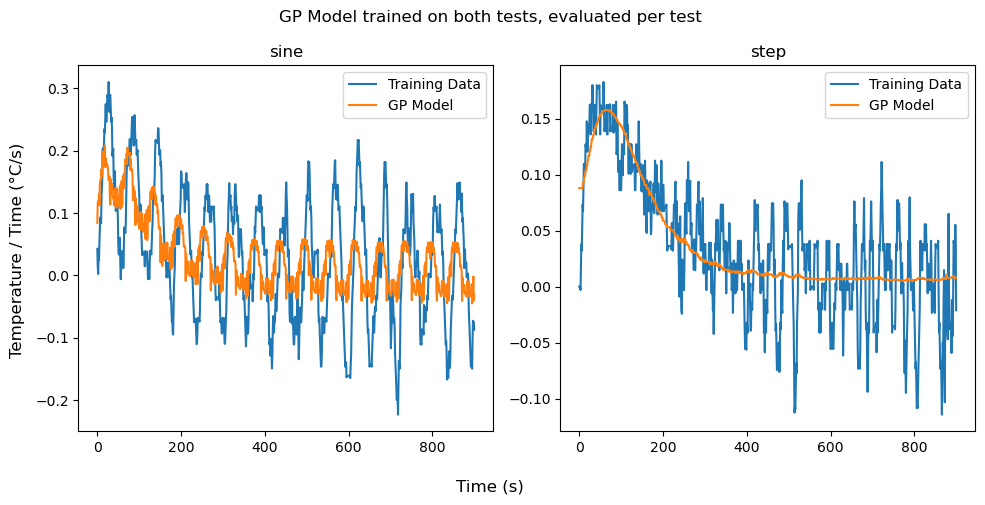

In [16]:
dTS1_GP = GP.evaluate()
dTS1_GP = [dTS1_GP[:len(tvec[0])], dTS1_GP[len(tvec[0])::]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("GP Model trained on both tests, evaluated per test")
fig.supxlabel("Time (s)")
fig.supylabel("Temperature / Time (°C/s)")
for i in ii:
    axs[i].plot(tvec[i], dTS1[i], label='Training Data')
    axs[i].plot(tvec[i], dTS1_GP[i], label='GP Model')
    axs[i].set_title(f"{tests[i]}")
    axs[i].legend()
fig.tight_layout()

## Integration

In [44]:
def dy_benchmark(t, y, *params):
    TH1, TS1 = y
    alpha, P1, T_amb, CpH, CpS, Ua, Ub, i = params
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f[i](t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

def dy_GP(t, y, *params):
    TH1, TS1 = y
    alpha, P1, T_amb, CpH, CpS, Ua, Ub, i = params
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f[i](t)) / CpH
    dTS1 = GP.evaluate([TS1, Q1f[i](t), dQ1f[i](t)], clean=True, SingleInstance=True)[0]
    return [dTH1, dTS1]

In [27]:
# Two-state model parameters [sine, step]:

alpha = [0.00016, 0.00016]                   # watts / (units P1 * percent U1)
P1 = [200, 200]                              # P1 units
T_amb = list(TS1[i][0] for i in ii)          # ambient temperature
CpH = [7.006, 6.6745]                        # J/degC
CpS = [0.01, 0.01]                           # J/degC
Ua = [0.051, 0.0491]                         # W/degC
Ub = [0.001, 0.0004]                         # W/degC

IC = list([T_amb[i], T_amb[i]] for i in ii)  # initial condition of states [TH1, TS1]

In [45]:
soln_benchmark = list(solve_ivp(dy_benchmark, 
                                [tvec[i][0], tvec[i][-1]], IC[i], t_eval=tvec[i], first_time=1, min_time=1, max_time=1, 
                                args=[alpha[i], P1[i], T_amb[i], CpH[i], CpS[i], Ua[i], Ub[i], i]) 
                      for i in ii)

soln_GP = list(solve_ivp(dy_GP, 
                         [tvec[i][0], tvec[i][-1]], IC[i], t_eval=tvec[i], first_time=1, min_time=1, max_time=1, 
                         args=[alpha[i], P1[i], T_amb[i], CpH[i], CpS[i], Ua[i], Ub[i], i]) 
               for i in ii)

In [46]:
TS1_benchmark = list(soln_benchmark[i].y[1] for i in ii)
TS1_GP = list(soln_GP[i].y[1] for i in ii)

## Comparison

In [47]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

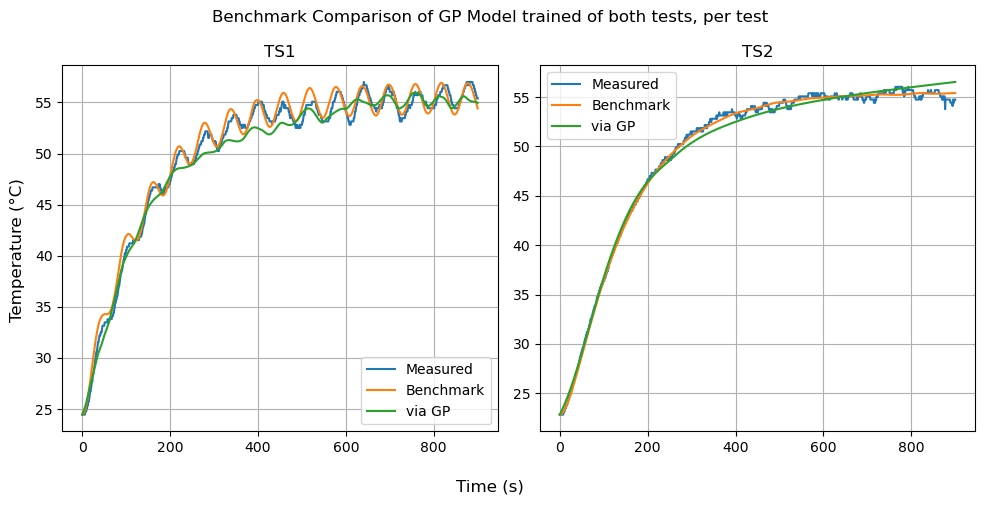

╒═══════════╤══════════╤══════════╕
│ RMSE      │     Sine │     Step │
╞═══════════╪══════════╪══════════╡
│ Benchmark │ 0.811618 │ 0.35852  │
├───────────┼──────────┼──────────┤
│ GP Model  │ 1.08593  │ 0.691779 │
╘═══════════╧══════════╧══════════╛


In [48]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Benchmark Comparison of GP Model trained of both tests, per test')
fig.supxlabel('Time (s)')
fig.supylabel('Temperature (°C)')
for i in ii:
    axs[i].set_title(f"TS{i + 1}")
    axs[i].plot(tvec[i], TS1[i], label=f"Measured")
    axs[i].plot(tvec[i], TS1_benchmark[i], label=f"Benchmark")
    axs[i].plot(tvec[i], TS1_GP[i], label=f"via GP")
    axs[i].legend()
    axs[i].grid()
fig.tight_layout()
plt.show()

RMSE_benchmark = list(_rmse(TS1[i], TS1_benchmark[i]) for i in ii)
RMSE_GP = list(_rmse(TS1[i], TS1_GP[i]) for i in ii)
print(tabulate([['RMSE', 'Sine', 'Step'], 
                ['Benchmark', RMSE_benchmark[0], RMSE_benchmark[1]], 
                ['GP Model', RMSE_GP[0], RMSE_GP[1]]], 
               headers='firstrow', tablefmt='fancy_grid'))